<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/prompts/W&B_Prompts_Quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{prompts-quickstart} -->

<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{prompts-quickstart} -->

**Weights & Biases Prompts** is a suite of LLMOps tools built for the development of LLM-powered applications. 

Use W&B Prompts to visualize and inspect the execution flow of your LLMs, analyze the inputs and outputs of your LLMs, view the intermediate results and securely store and manage your prompts and LLM chain configurations.

## Installation

In [20]:
!pip install "wandb>=0.15.2" -qqq
!pip install "langchain>=v0.0.158" openai -qqq

## Setup

This demo requires that you have an [OpenAI key](https://platform.openai.com)

In [ ]:
import os
from getpass import getpass

if os.getenv("OPENAI_API_KEY") is None:
  os.environ["OPENAI_API_KEY"] = getpass("Paste your OpenAI key from: https://platform.openai.com/account/api-keys\n")
assert os.getenv("OPENAI_API_KEY", "").startswith("sk-"), "This doesn't look like a valid OpenAI API key"
print("OpenAI API key configured")

# W&B Prompts

W&B currently supports a tool called __Trace__. Trace consists of three main components:

**Trace table**: Overview of the inputs and outputs of a chain.

**Trace timeline**: Displays the execution flow of the chain and is color-coded according to component types.

**Model architecture**: View details about the structure of the chain and the parameters used to initialize each component of the chain.

After running this section, you will see a new panel automatically created in your workspace, showing each execution, the trace, and the model architecture


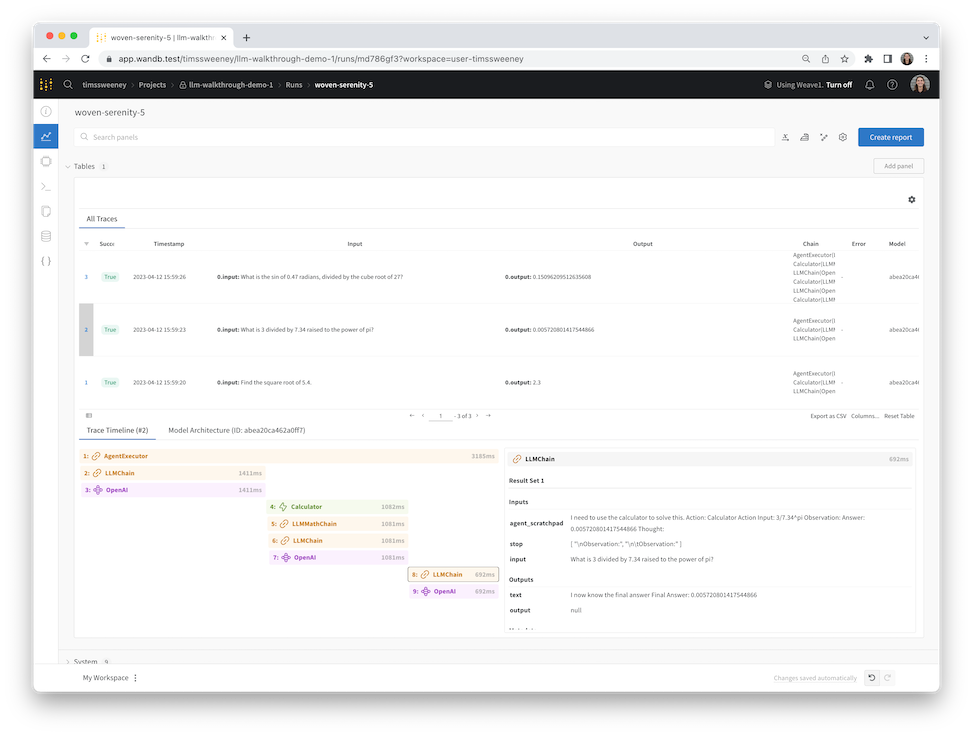


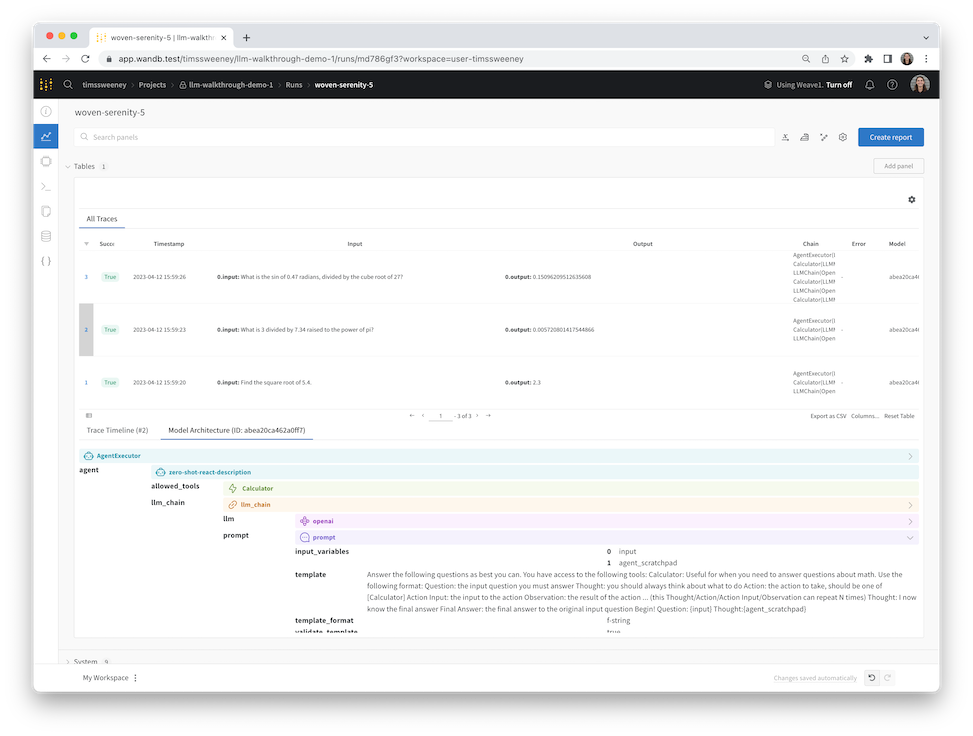

Import `WandbTracer`and optionally define a dictionary with arguments for `wandb.init()` that will later be passed to `WandbTracer`. This includes a project name, team name, entity, and more. For more information about wandb.init, see the API Reference Guide.

In [6]:
from wandb.integration.langchain import WandbTracer

wandb_config = {"project": "wandb_prompts_quickstart"}

### Maths with LangChain

In [7]:
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.llms import OpenAI

In [12]:
llm = OpenAI(temperature=0)
tools = load_tools(["llm-math"], llm=llm)
agent = initialize_agent(tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION)

Pass `WandbTracer` when you call your LangChain chain or agent to log your trace to W&B

In [19]:
questions = [
    "Find the square root of 5.4.",
    "What is 3 divided by 7.34 raised to the power of pi?",
    "What is the sin of 0.47 radians, divided by the cube root of 27?",
    "what is 1 divided by zero"
]
for question in questions:
  try:
    answer = agent.run(question, callbacks=[WandbTracer(wandb_config)])
    print(answer)
  except Exception as e:
    print(e)
    pass

When you're finished your session, it is best practice to call `WandbTracer.finish()` to ensure your wandb run closes cleanly.

In [ ]:
WandbTracer.finish()

# Non-Lang Chain Implementation

What if you don't want to use Langchain - in particular you want to write an integration or instrucment your teams code? That is completely ok! Let's learn about `TraceTree` and `Span`!

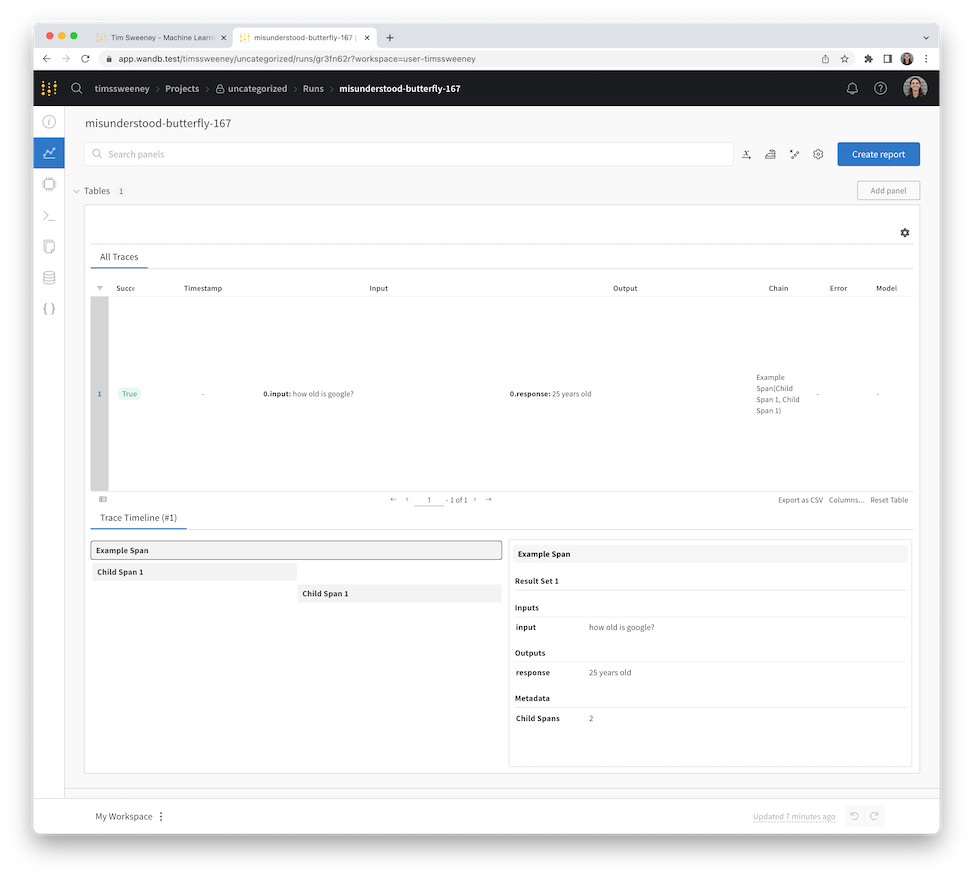

**Note:** W&B Runs support logging as many traces you needed to a single run, i.e. you can make multiple calls of `run.log` without the need to create a new run each time

In [21]:
from wandb.sdk.data_types import trace_tree
import wandb

A Span represents a unit of work, Spans can have type `AGENT`, `TOOL`, `LLM` or `CHAIN`

In [22]:
parent_span = trace_tree.Span(name="Example Span", span_kind = trace_tree.SpanKind.AGENT)

Spans can (and should!) be nested:

In [ ]:
# Create a span for a call to a Tool
tool_span = trace_tree.Span(name="Tool 1", span_kind = trace_tree.SpanKind.TOOL)

# Create a span for a call to a LLM Chain
chain_span = trace_tree.Span(name="LLM CHAIN 1", span_kind = trace_tree.SpanKind.CHAIN)

# Create a span for a call to a LLM that is called by the LLM Chain
llm_span = trace_tree.Span(name="LLM 1", span_kind = trace_tree.SpanKind.LLM)
chain_span.add_child_span(llm_span)

Span Inputs and Outputs can be added like so:

In [ ]:
tool_span.add_named_result({"input": "search: google founded in year"}, {"response": "1998"})
chain_span.add_named_result({"input": "calculate: 2023 - 1998"}, {"response": "25"})
llm_span.add_named_result({"input": "calculate: 2023 - 1998", "system": "you are a helpful assistant", }, 
                          {"response": "25", "tokens_used":218})

parent_span.add_child_span(tool_span)
parent_span.add_child_span(chain_span)

parent_span.add_named_result({"user": "calculate: 2023 - 1998"}, 
                             {"response": "25 years old"})

You can then log the parent_span to W&B like as below. 

In [ ]:
run = wandb.init(name="manual_span_demo", project="wandb_prompts_demo")
run.log({"trace": trace_tree.WBTraceTree(parent_span)})
run.finish()

Clicking on the W&B Run link generated will take you to a workspace where you can inspect the Trace created